In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
%matplotlib inline

/Users/yunqiguo/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. Generate the real_X and real_Y dataset

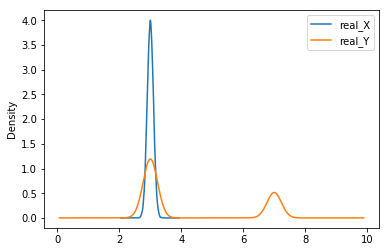

In [2]:
def sample_batch(sample_size):
    mu, sigma = 3, 0.1 # mean and standard deviation
    real_X = np.random.normal(mu, sigma, [sample_size, 1])
#     real_X = np.random.uniform(0, 2, [sample_size, 1])
    real_X = tf.convert_to_tensor(real_X, dtype=tf.float32)
    real_Y = prob(real_X)
    return real_X, real_Y

def prob(X):
    return X + 4. * tf.distributions.Bernoulli(probs = 0.3, dtype = tf.float32).sample(tf.shape(X))

with tf.Session() as sess:
    real_X, real_Y = sess.run(sample_batch(50000))
    df = pd.DataFrame({"real_X": real_X.flatten(), "real_Y": real_Y.flatten()})
    plot = df.plot(kind='density')

### 2. Build the adversarial nets

In [3]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.0)
    return tf.random_normal(shape = size, stddev = xavier_stddev)

X = tf.placeholder(tf.float32, shape = [None, 1])
Y = tf.placeholder(tf.float32, shape = [None, 1])

D_W1 = tf.Variable(xavier_init([1,100]))
D_b1 = tf.Variable(tf.zeros(shape = [100]))

D_W2 = tf.Variable(xavier_init([100,1]))
D_b2 = tf.Variable(tf.zeros(shape = [1]))

theta_D = [D_W1, D_b1, D_W2, D_b2]

Z = tf. placeholder(tf.float32, shape = [None, 100])

G_W1 = tf.Variable(xavier_init([100, 10]))
G_b1 = tf.Variable(tf.zeros(shape = [10]))

G_W2 = tf.Variable(xavier_init([10, 1]))
G_b2 = tf.Variable(tf.zeros(shape = [1]))

theta_G = [G_W1, G_b1, G_W2, G_b2]

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size = [m, n])

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_x = G_log_prob
    
    return G_x

def discriminator(y):
    D_h1 = tf.nn.relu(tf.matmul(y, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    
    return D_prob, D_logit

def plot(real_X, real_Y, G_X, G_Y ):
    df = pd.DataFrame({"real_X": real_X.flatten(), "real_Y": real_Y.flatten(), "fake_X": G_X.flatten(), "fake_Y": G_Y.flatten()})
    plot = df.plot(kind='density')
    fig = plot.get_figure()
    return fig

G_sample_X = generator(Z)
G_sample_Y = prob(G_sample_X)

D_real, D_logit_real = discriminator(Y)
D_fake, D_logit_fake = discriminator(G_sample_Y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# mb_size = 128
mb_size = 256
Z_dim = 100

sess = tf.Session()
sess.run(tf.global_variables_initializer())

output_dis = 'result_6/'

if not os.path.exists(output_dis):
    os.makedirs(output_dis)

i = 0
    
for it in range(1000):
    if it % 50 == 0:
        real_X, real_Y = sess.run(sample_batch(mb_size * 10))
        samples_X = sess.run(G_sample_X, feed_dict={Z: sample_Z(mb_size * 10, Z_dim)})
        samples_Y = sess.run(G_sample_Y, feed_dict={G_sample_X: samples_X})
        fig = plot(real_X, real_Y, samples_X, samples_Y)
        plt.savefig((output_dis + '/{}.png').format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    real_X, real_Y = sess.run(sample_batch(mb_size))

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: real_X, Y:real_Y, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 10 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D_loss: 11.88
G_loss: 4.26
()
Iter: 10
D_loss: 9.478
G_loss: 3.404
()
Iter: 20
D_loss: 7.212
G_loss: 2.907
()
Iter: 30
D_loss: 4.699
G_loss: 2.4
()
Iter: 40
D_loss: 2.679
G_loss: 1.97
()
Iter: 50
D_loss: 1.32
G_loss: 1.331
()
Iter: 60
D_loss: 0.9925
G_loss: 1.116
()
Iter: 70
D_loss: 1.218
G_loss: 0.8249
()
Iter: 80
D_loss: 1.242
G_loss: 0.9021
()
Iter: 90
D_loss: 1.238
G_loss: 0.7304
()
Iter: 100
D_loss: 1.236
G_loss: 0.7076
()
Iter: 110
D_loss: 1.197
G_loss: 0.6896
()
Iter: 120
D_loss: 1.24
G_loss: 0.7112
()
Iter: 130
D_loss: 1.244
G_loss: 0.6473
()
Iter: 140
D_loss: 1.221
G_loss: 0.6542
()
Iter: 150
D_loss: 1.238
G_loss: 0.6773
()
Iter: 160
D_loss: 1.177
G_loss: 0.6844
()
Iter: 170
D_loss: 1.12
G_loss: 0.7473
()
Iter: 180
D_loss: 1.169
G_loss: 0.7572
()
Iter: 190
D_loss: 1.146
G_loss: 0.7388
()
Iter: 200
D_loss: 1.117
G_loss: 0.8331
()
Iter: 210
D_loss: 1.047
G_loss: 0.8224
()
Iter: 220
D_loss: 1.11
G_loss: 0.8516
()
Iter: 230
D_loss: 1.083
G_loss: 0.8858
()
Iter: 240
D_loss:

In [4]:
for it in range(1000, 3000):
    if it % 50 == 0:
        real_X, real_Y = sess.run(sample_batch(mb_size * 10))
        samples_X = sess.run(G_sample_X, feed_dict={Z: sample_Z(mb_size * 10, Z_dim)})
        samples_Y = sess.run(G_sample_Y, feed_dict={G_sample_X: samples_X})
        fig = plot(real_X, real_Y, samples_X, samples_Y)
        plt.savefig((output_dis + '/{}.png').format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    real_X, real_Y = sess.run(sample_batch(mb_size))

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: real_X, Y:real_Y, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 10 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 1000
D_loss: 1.331
G_loss: 0.7832
()
Iter: 1010
D_loss: 1.327
G_loss: 0.7466
()
Iter: 1020
D_loss: 1.333
G_loss: 0.7571
()
Iter: 1030
D_loss: 1.336
G_loss: 0.7614
()
Iter: 1040
D_loss: 1.335
G_loss: 0.7425
()
Iter: 1050
D_loss: 1.333
G_loss: 0.7882
()
Iter: 1060
D_loss: 1.314
G_loss: 0.743
()
Iter: 1070
D_loss: 1.299
G_loss: 0.7701
()
Iter: 1080
D_loss: 1.367
G_loss: 0.7376
()
Iter: 1090
D_loss: 1.322
G_loss: 0.7777
()
Iter: 1100
D_loss: 1.32
G_loss: 0.742
()
Iter: 1110
D_loss: 1.348
G_loss: 0.7495
()
Iter: 1120
D_loss: 1.338
G_loss: 0.758
()
Iter: 1130
D_loss: 1.349
G_loss: 0.7628
()
Iter: 1140
D_loss: 1.33
G_loss: 0.7295
()
Iter: 1150
D_loss: 1.336
G_loss: 0.7723
()
Iter: 1160
D_loss: 1.337
G_loss: 0.7675
()
Iter: 1170
D_loss: 1.353
G_loss: 0.6976
()
Iter: 1180
D_loss: 1.363
G_loss: 0.7287
()
Iter: 1190
D_loss: 1.355
G_loss: 0.7422
()
Iter: 1200
D_loss: 1.353
G_loss: 0.747
()
Iter: 1210
D_loss: 1.331
G_loss: 0.7449
()
Iter: 1220
D_loss: 1.322
G_loss: 0.7212
()
Iter: 1230
D_loss

Iter: 2920
D_loss: 1.39
G_loss: 0.6378
()
Iter: 2930
D_loss: 1.385
G_loss: 0.6813
()
Iter: 2940
D_loss: 1.39
G_loss: 0.6898
()
Iter: 2950
D_loss: 1.382
G_loss: 0.7057
()
Iter: 2960
D_loss: 1.386
G_loss: 0.6949
()
Iter: 2970
D_loss: 1.387
G_loss: 0.6915
()
Iter: 2980
D_loss: 1.388
G_loss: 0.6872
()
Iter: 2990
D_loss: 1.387
G_loss: 0.7064
()


In [5]:
for it in range(3000, 5000):
    if it % 50 == 0:
        real_X, real_Y = sess.run(sample_batch(mb_size * 10))
        samples_X = sess.run(G_sample_X, feed_dict={Z: sample_Z(mb_size * 10, Z_dim)})
        samples_Y = sess.run(G_sample_Y, feed_dict={G_sample_X: samples_X})
        fig = plot(real_X, real_Y, samples_X, samples_Y)
        plt.savefig((output_dis + '/{}.png').format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    real_X, real_Y = sess.run(sample_batch(mb_size))

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: real_X, Y:real_Y, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 10 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 3000
D_loss: 1.386
G_loss: 0.6927
()
Iter: 3010
D_loss: 1.387
G_loss: 0.6859
()
Iter: 3020
D_loss: 1.388
G_loss: 0.6572
()
Iter: 3030
D_loss: 1.386
G_loss: 0.6727
()
Iter: 3040
D_loss: 1.386
G_loss: 0.6708
()
Iter: 3050
D_loss: 1.383
G_loss: 0.7044
()
Iter: 3060
D_loss: 1.384
G_loss: 0.7145
()
Iter: 3070
D_loss: 1.386
G_loss: 0.7016
()
Iter: 3080
D_loss: 1.387
G_loss: 0.7088
()
Iter: 3090
D_loss: 1.387
G_loss: 0.6873
()
Iter: 3100
D_loss: 1.386
G_loss: 0.6786
()
Iter: 3110
D_loss: 1.387
G_loss: 0.6665
()
Iter: 3120
D_loss: 1.386
G_loss: 0.7167
()
Iter: 3130
D_loss: 1.385
G_loss: 0.7233
()
Iter: 3140
D_loss: 1.385
G_loss: 0.6994
()
Iter: 3150
D_loss: 1.387
G_loss: 0.6663
()
Iter: 3160
D_loss: 1.388
G_loss: 0.6959
()
Iter: 3170
D_loss: 1.384
G_loss: 0.7182
()
Iter: 3180
D_loss: 1.385
G_loss: 0.701
()
Iter: 3190
D_loss: 1.387
G_loss: 0.6793
()
Iter: 3200
D_loss: 1.387
G_loss: 0.6809
()
Iter: 3210
D_loss: 1.386
G_loss: 0.6802
()
Iter: 3220
D_loss: 1.387
G_loss: 0.7025
()
Iter: 3230
D

KeyboardInterrupt: 

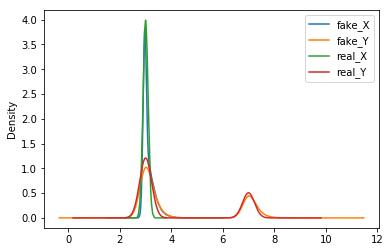

In [9]:
samples_X = sess.run(G_sample_X, feed_dict={Z: sample_Z(50000, Z_dim)})
samples_Y = sess.run(G_sample_Y, feed_dict={G_sample_X: samples_X})
real_X, real_Y = sess.run(sample_batch(50000))
_ = plot(real_X, real_Y, samples_X, samples_Y)

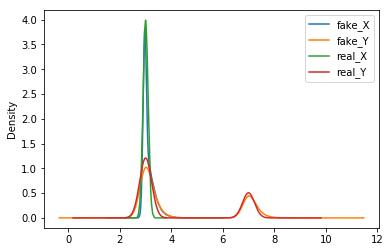

In [10]:
fig = plot(real_X, real_Y, samples_X, samples_Y)
plt.savefig((output_dis + '/final.png').format(str(i).zfill(3)), bbox_inches='tight')